## Accessing ESA WorldCover classification data with the Planetary Computer STAC API

The European Space Agency (ESA) [WorldCover](https://esa-worldcover.org/en) product provides global land cover maps for the years 2020 and 2021 at 10 meter resolution based on the combination of [Sentinel-1](https://sentinel.esa.int/web/sentinel/missions/sentinel-1) radar data and [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) imagery. The discrete classification maps provide 11 classes defined using the Land Cover Classification System (LCCS) developed by the United Nations (UN) Food and Agriculture Organization (FAO). The map images are stored in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

Two versions of the WorldCover product are available:

- WorldCover 2020 produced using v100 of the algorithm ([User Manual](https://esa-worldcover.s3.eu-central-1.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf))
- WorldCover 2021 produced using v200 of the algorithm ([User Manual](https://esa-worldcover.s3.eu-central-1.amazonaws.com/v200/2021/docs/WorldCover_PUM_V2.0.pdf))

Since the WorldCover maps for 2020 and 2021 were generated with different algorithm versions (v100 and v200, respectively), changes between the maps include both changes in real land cover and changes due to the used algorithms.

### Data Access

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. If you are using the [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) to run this notebook, then your API key is automatically set to the environment variable `PC_SDK_SUBSCRIPTION_KEY` for you when your server is started. Otherwise, you can view your keys by signing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be manually set via the environment variable `PC_SDK_SUBSCRIPTION_KEY` or the following code:

```python
import planetary_computer
planetary_computer.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available in [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

### Define the area of interest and search the collection

Let's define a bounding box around Mount Elgon, which sits on the border of Uganda and Kenya.

In [1]:
bbox_of_interest = [33.984, 0.788, 34.902, 1.533]

Use [pystac-client](https://github.com/stac-utils/pystac-client) to search over the ESA WorldCover collection.

In [2]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["esa-worldcover"],
    bbox=bbox_of_interest,
)

items = list(search.get_items())
items

[<Item id=ESA_WorldCover_10m_2020_v100_N00E033>]

### Available Assets & Metadata

Our search returned one item, a 3x3 degree tile of classification data. Let's display the available assets and metadata. 

In [3]:
import rich.table

# Assets
t_assets = rich.table.Table("Key", "Value")
for key, asset in items[0].assets.items():
    t_assets.add_row(key, asset.title)
t_assets

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Value                           ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ map              │ Land Cover Classes              │
│ tilejson         │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview                │
└──────────────────┴─────────────────────────────────┘

In [4]:
# Metadata
t_metadata = rich.table.Table("Key", "Value")
for k, v in sorted(items[0].properties.items()):
    t_metadata.add_row(k, str(v))
t_metadata

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                         ┃ Value                                                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ created                     │ 2022-05-16T16:37:31.807816Z                            │
│ datetime                    │ None                                                   │
│ description                 │ ESA WorldCover product at 10m resolution for year 2020 │
│ end_datetime                │ 2020-12-31T23:59:59Z                                   │
│ esa_worldcover:product_tile │ N00E033                                                │
│ instruments                 │ ['c-sar', 'msi']                                       │
│ mission                     │ sentinel-1, sentinel-2                                 │
│ platform                    │ sentinel-1a, sentinel-1b, sentinel-2a, sentinel-2b     │
│ proj:epsg                   │ 4326                                                   │
│ start_datetime              │ 2020-01-01T00:00:00Z                                   │
└─────────────────────────────┴────────────────────────────────────────────────────────┘

The `map` asset contains the full resolution data, but we can use the `rendered_preview` asset to quickly visualize the Item data using the Planetary Computer's data API.

In [5]:
from IPython.display import Image

Image(url=items[0].assets["rendered_preview"].href)

### Render our area of interest


Let's create a plot of our area of interest. This dataset includes classification information which maps raster values to class descriptions and preferred colors. We'll want to use this information when plotting the data. We can extract it from the `map` asset.

In [6]:
class_list = items[0].assets["map"].extra_fields["classification:classes"]
classmap = {
    c["value"]: {"description": c["description"], "hex": c["color-hint"]}
    for c in class_list
}

t = rich.table.Table("Value", "Description", "Hex Color")
for k, v in classmap.items():
    t.add_row(str(k), v["description"], v["hex"])
t

┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Value ┃ Description              ┃ Hex Color ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 10    │ Tree cover               │ 006400    │
│ 20    │ Shrubland                │ FFBB22    │
│ 30    │ Grassland                │ FFFF4C    │
│ 40    │ Cropland                 │ F096FF    │
│ 50    │ Built-up                 │ FA0000    │
│ 60    │ Bare / sparse vegetation │ B4B4B4    │
│ 70    │ Snow and ice             │ F0F0F0    │
│ 80    │ Permanent water bodies   │ 0064C8    │
│ 90    │ Herbaceous wetland       │ 0096A0    │
│ 95    │ Mangroves                │ 00CF75    │
│ 100   │ Moss and lichen          │ FAE6A0    │
└───────┴──────────────────────────┴───────────┘

We'll use this class information to create a custom colormap for plotting the data and to extract data that we need to add an informative colorbar to the plot.

In [7]:
import matplotlib.colors

colors = ["#000000" for r in range(256)]
for key, value in classmap.items():
    colors[int(key)] = f"#{value['hex']}"
cmap = matplotlib.colors.ListedColormap(colors)

# sequences needed for an informative colorbar
values = [key for key in classmap]
boundaries = [(values[i + 1] + values[i]) / 2 for i in range(len(values) - 1)]
boundaries = [0] + boundaries + [255]
ticks = [(boundaries[i + 1] + boundaries[i]) / 2 for i in range(len(boundaries) - 1)]
tick_labels = [value["description"] for value in classmap.values()]

Load the data from our area of interest using `odc-stac`.

In [8]:
import odc.stac

ds = odc.stac.load(items, crs="EPSG:4326", resolution=0.0001, bbox=bbox_of_interest)
map_data = ds["map"].isel(time=-1).load()
map_data

<xarray.DataArray 'map' (latitude: 7450, longitude: 9180)>
array([[30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 20, 20],
       [30, 30, 30, ..., 30, 30, 30],
       ...,
       [40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40]], dtype=uint8)
Coordinates:
  * latitude     (latitude) float64 1.533 1.533 1.533 ... 0.7882 0.7881 0.788
  * longitude    (longitude) float64 33.98 33.98 33.98 33.98 ... 34.9 34.9 34.9
    spatial_ref  int32 4326
    time         datetime64[ns] 2020-01-01
Attributes:
    nodata:   0

Finally, we can plot our area of interest with a colorbar labeled with the class descriptions.

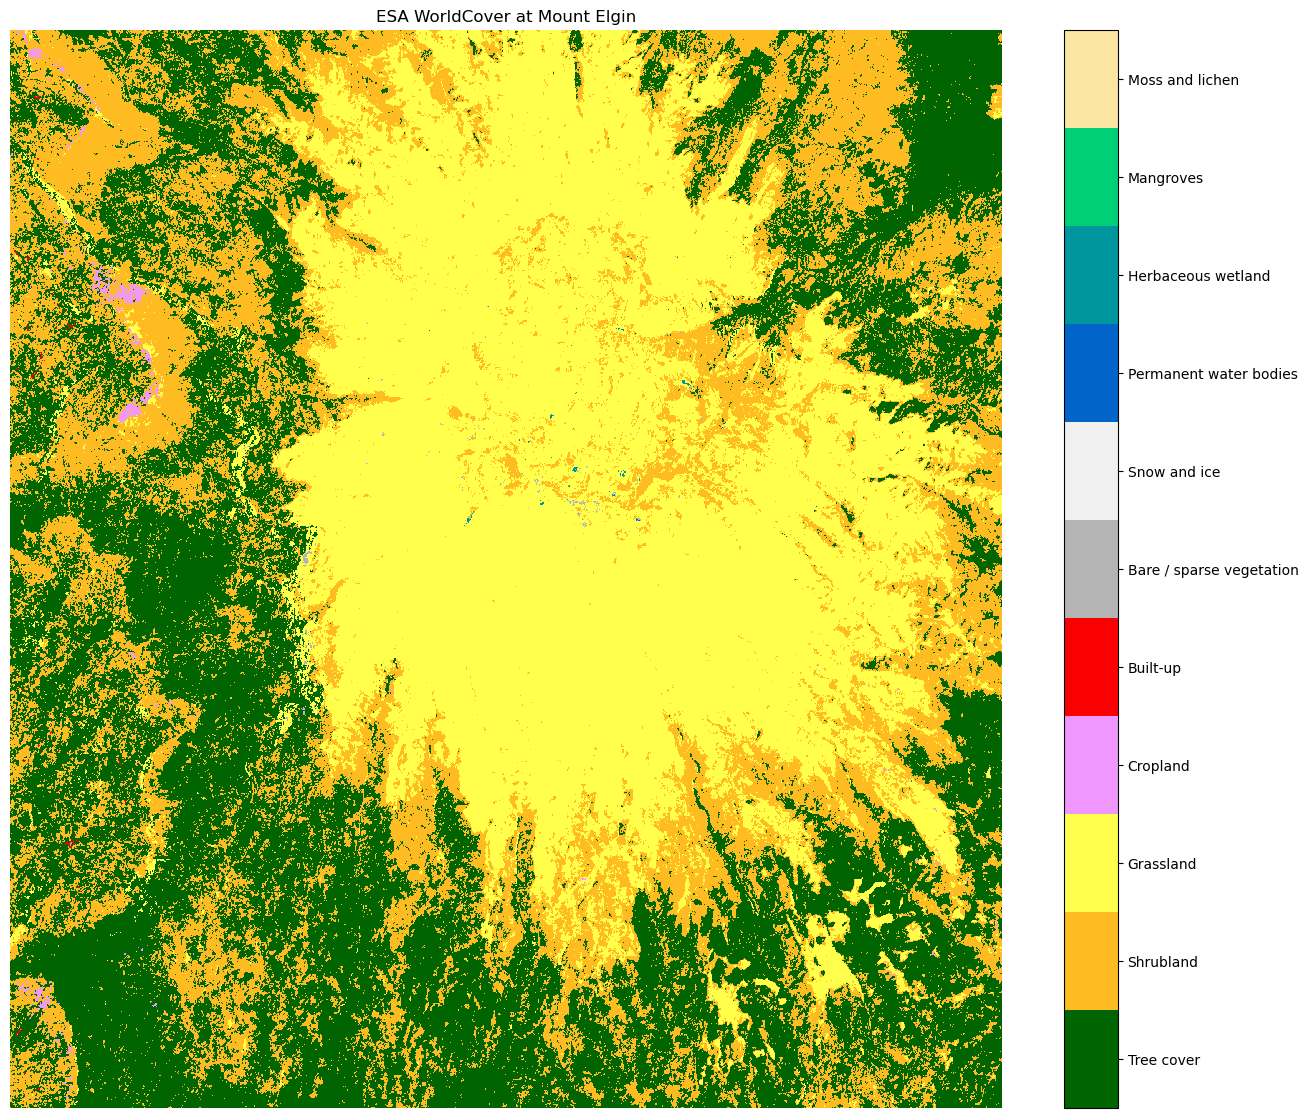

In [9]:
from matplotlib import cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 14))
normalizer = matplotlib.colors.Normalize(vmin=0, vmax=255)

map_data.isel(latitude=slice(3000, 6000), longitude=slice(4000, 7000)).plot(
    ax=ax, cmap=cmap, norm=normalizer
)

colorbar = fig.colorbar(
    cm.ScalarMappable(norm=normalizer, cmap=cmap),
    boundaries=boundaries,
    values=values,
    cax=fig.axes[1].axes,
)
colorbar.set_ticks(ticks, labels=tick_labels)

ax.set_axis_off()
ax.set_title("ESA WorldCover at Mount Elgin");